# Project 1: Bank Credit
adrianty & sondrewo

## Table of contents:

* [Implicit assumptions and discussion](#first-bullet)
* [Model Development](#second-bullet)
    * [Hypothesis and heuristics](#third-bullet)
    * [Exp 1: Comparing different classification models](#foruth-bullet)    
    * [Exp 2: Feautre Selection](#fifth-bullet)
    * [Exp 3: Comparison with RandomBanker.py](#fifth-bullet) 
* [Fairness](#sixth-bullet)
* [Reproducibility and reliability](#seventh-bullet)
* [Privacy](#eight-bullet)


   

## Implicit assumptions of the data

The data was already labeled with some named columns in the provided TestLending script. We still decided to do some explorative testing, to see if we could use some heuristics to develop some additional understanding of the data. We found out that there were many more elements that were labelled with <em>2</em>, which is described in the documentation as <em>bad</em>, than there were those that were labelled with <em>1</em>, or <em>good</em>. Further inspection revealed that the average amount for the <em>bad</em> loans were quite a lot higher than the <em>good</em> ones. This could suggest that the data is taken from a position in time where the <em>bad</em> loans have already defaulted, and the <em>good</em> ones are in the process of being paid off.

This of course would make modelling extremely difficult, as we would have to normalize the amounts for the duration remaining. This would be extremely speculative and probably not make for good generalization, so we make the assumption that this is not the case, and that the duration and amount listed are initial values.

## Model development

## Intro

We started our model development by inspecting the different columns in the data set, identifying both numerical and discrete  features. As is well known, the Naive Bayes classifier supports catergorical features natively and can be adjusted to use numerical ones as well. Thus, we formulated the following hypothesis:

<strong>H</strong><sub>0</sub> : The Multinomial Naive Bayes classifier will provide a high accuracy

We then attempted to falsify this hypothesis (Exp 1) by testing out different models: Logistic regression, KNN, BernoulliNB, AdaBoost with Decision Tree and a simple multi-layered perceptron (MLP).

## Setup

In [1]:
class NameBanker:
    def __init__(self, MODEL):
        self.model = MODEL
    
    def fit(self, X, y):
        self.data = [X, y]
        self.model.fit(X, y)

    def set_interest_rate(self, rate):
        self.rate = rate
        return

    def predict_proba(self, x):
        return self.model.predict_proba(np.array(x).reshape(1, -1))[0]

    def expected_utility(self, x, action):
        """
        Calculates the expected utility of an individual. Uses the formula
        
        utility = amount_of_loan * (1 + lend_rate)^duration_of_loan
        """
        utility = x["amount"] * ((1 + self.rate) ** x['duration'])
        
        # Generate a utility matrix for the loan.
        # will look like this for a utility of 100 for a loan of 20:
        
        #                    ___________________
        #                   |will pay | wont pay|
        # ------------------|---------|---------|
        # dont give loan    |    0    |    0    |
        #-------------------|---------|---------|
        # do give loan      |   100   |  - 20   |
        #----------------------------------------
        U = np.matrix(f"0 0; {utility} {x['amount'] * -1}")

        # get the probabilities of the classes (will pay, wont pay)
        probs = self.predict_proba(x)
        
        # get the index of the highest probability - 0 if wont pay, 1 if will pay
        repaid = np.where(probs == max(probs))

        return U[action, repaid]

    def get_best_action(self, x):
        """
        Decide whether to give a loan to some individual x.
        
        Returns:
            the index of the highest expected utility - 0 if loan denied, 1 if loan given
        """
        util = [self.expected_utility(x, a) for a in [0,1]]
        return util.index(max(util))

In [2]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import pandas
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random_banker

In [3]:
PATH = "./data/credit/D_valid.csv"
features = ['checking account balance', 'duration', 'credit history',
            'purpose', 'amount', 'savings', 'employment', 'installment',
            'marital status', 'other debtors', 'residence time',
            'property', 'age', 'other installments', 'housing', 'credits',
            'job', 'persons', 'phone', 'foreign']
target = 'repaid'

df = pandas.read_csv(PATH, sep=' ',
                     names=features+[target])

In [4]:
numerical_features = ['duration', 'age', 'residence time', 'installment', 'amount', 'persons', 'credits']
quantitative_features = list(filter(lambda x: x not in numerical_features, features))
X = pandas.get_dummies(df, columns=quantitative_features, drop_first=True)
encoded_features = list(filter(lambda x: x != target, X.columns))

In [5]:
def test_decision_maker(X_test, y_test, interest_rate, decision_maker):
    n_test_examples = len(X_test)
    utility = 0

    ## Example test function - this is only an unbiased test if the data has not been seen in training
    total_amount = 0
    total_utility = 0
    decision_maker.set_interest_rate(interest_rate)
    for t in range(n_test_examples):
        action = decision_maker.get_best_action(X_test.iloc[t])
        good_loan = y_test.iloc[t] # assume the labels are correct
        duration = X_test['duration'].iloc[t]
        amount = X_test['amount'].iloc[t]
        # If we don't grant the loan then nothing happens
        if (action==1):
            if (good_loan != 1):
                utility -= amount
            else:
                utility += amount*(pow(1 + interest_rate, duration) - 1)
        total_utility += utility
        total_amount += amount
    return utility, total_utility/total_amount

In [6]:
interest_rate = 0.017
n_tests = 100

### Do a number of preliminary tests by splitting the data in parts
def run_test(models, encoded_features=encoded_features):
    '''
    args:
        models (dict): dictionary of models to test on. key=str (name of model), value=model
    returns:
        results: dictionary of the total utility and avg investment return per n, per model
    '''
    results = {}
    for name, model in models.items():
        decision_maker = NameBanker(model)
        utility = 0
        investment_return = 0
        for iter in range(n_tests):
            X_train, X_test, y_train, y_test = train_test_split(X[encoded_features], X[target], test_size=0.2)
            decision_maker.set_interest_rate(interest_rate)
            decision_maker.fit(X_train, y_train)
            Ui, Ri = test_decision_maker(X_test, y_test, interest_rate, decision_maker)
            utility += Ui
            investment_return += Ri
        results[name] = [math.floor((utility / n_tests) * 100)/100.0, math.floor((investment_return / n_tests) * 100)/100.0]
    return results, decision_maker

## Exp 1: Comparing different classification models:

In [133]:
results = run_test({"KNN": KNeighborsClassifier(n_neighbors=31),
                    "BernoulliNB": BernoulliNB(),
                    "MultinomialNB": MultinomialNB(),
                    "Log.regression": LogisticRegression(max_iter=1500),
                    "Neural Net": MLPClassifier(alpha=1, max_iter=1000)})

In [135]:
pandas.DataFrame(results[0].items(), columns=["Model", "Total Utility, Avg Investment Return"])

,Model,"Total Utility, Avg Investment Return"
0,KNN,"[439654.75, 10.4]"
1,BernoulliNB,"[1945987.68, 49.59]"
2,MultinomialNB,"[4305384.29, 97.84]"
3,Log.regression,"[1632840.04, 38.29]"
4,Neural Net,"[1352309.87, 37.72]"


### Results of Exp 1:

Based on these results, we chose to keep our hypothesis H<sub>0</sub> and continue the development using the Multinomial NB model as a baseline.

<b> Assumption 1 </b>: 
    Since the results for Multinomial NB was that much better than for KNN, we assumed that changing the amount of neighbours would not out-perform NB and decided to only test for `k=floor(sqrt(n))=31` (a common approach for K selection for KNN)


## Exp 2:  Feature selection

Next, we decided to try forward stepwise feature selection, based on the lab session by Dirk Hesse, using the baseline model.

In [202]:
from sklearn.model_selection import cross_val_score

In [204]:
classifier = MultinomialNB()

### Feature Selection

In [207]:
def stepwise_selection(features): #Credit: Dirk's notebooks
    columns = list(features.columns)
    selected_features = []
    scores = []
    N = 10
    while len(selected_features) < N:
        best_score = pandas.Series([0])
        best_feature = None
        for feature in columns:
            score = cross_val_score(classifier,
                                   features[selected_features + [feature]], X[target])
            if score.mean() > best_score.mean():
                best_feature = feature
                best_score = score
        print(f"{best_feature}: {best_score} ({best_score.mean()})")
        columns.remove(best_feature)
        selected_features.append(best_feature)
        scores.append(best_score)
    return scores, selected_features

In [205]:
scores, selected_features = stepwise_selection(X)

duration: [0.635 0.635 0.635 0.635 0.635] (0.635)
repaid: [0.645 0.66  0.64  0.67  0.645] (0.652)
savings_4: [0.69  0.68  0.655 0.665 0.695] (0.677)
checking account balance_3: [0.69  0.7   0.69  0.69  0.725] (0.6990000000000001)
installment: [0.785 0.745 0.765 0.74  0.77 ] (0.761)
savings_5: [0.835 0.805 0.77  0.74  0.785] (0.7870000000000001)
purpose_6: [0.82  0.81  0.77  0.765 0.795] (0.792)
marital status_3: [0.83  0.8   0.79  0.785 0.8  ] (0.8009999999999999)
employment_4: [0.84  0.805 0.79  0.785 0.8  ] (0.804)
housing_3: [0.845 0.81  0.795 0.785 0.8  ] (0.807)


<strong> FIG 1 </strong>

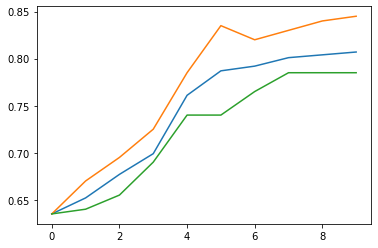

In [206]:
plt.plot([s.mean() for s in scores])
plt.plot([s.max() for s in scores])
plt.plot([s.min() for s in scores])

In [126]:
results_exp2 = run_test({"MultinomialNB, with opt. columns": classifier}, selected_features + ["amount"])

In [127]:
pandas.DataFrame(results_exp2[0].items(), columns=["Model", "Total Utility, Avg Investment Return"])

,Model,"Total Utility, Avg Investment Return"
0,"MultinomialNB, with opt. columns","[5034088.23, 112.35]"


### Results of Exp 2:

We found that after eight paramters, there was no further pay off in utility for our model (See Fig.1). This might have differed based on the order of the columns, but we assume that the difference would not be that substantial. 

## Exp 3: Comparison with RandomBanker.py

In [128]:
def run_test_single_model(maker):
    res = []
    decision_maker = maker
    utility = 0
    investment_return = 0
    for iter in range(n_tests):
        X_train, X_test, y_train, y_test = train_test_split(X[encoded_features], X[target], test_size=0.2)
        decision_maker.set_interest_rate(interest_rate)
        decision_maker.fit(X_train, y_train)
        Ui, Ri = test_decision_maker(X_test, y_test, interest_rate, decision_maker)
        utility += Ui
        investment_return += Ri
    
    res.append(math.floor((utility / n_tests) * 100)/100.0)
    res.append(math.floor((investment_return / n_tests) * 100)/100.0)
    return res

In [129]:
comp_test = {}
comp_test["Random banker"] = run_test_single_model(random_banker.RandomBanker())
comp_test["Name banker (our model)"] = run_test_single_model(NameBanker(MultinomialNB()))

In [130]:
pandas.DataFrame(comp_test.items(), columns=["Model", "Total Utility, Avg Investment Return"])

,Model,"Total Utility, Avg Investment Return"
0,Random banker,"[1288531.13, 30.17]"
1,Name banker (our model),"[5116939.46, 131.32]"


### Results of Exp 3

The table above shows that our model performed better than the random banker module by quite a substantial amount.

# PART 2

### Fairness

We want to measure fairness in our model. One way to do that is through the p-percent metric:

$$ p\%-score=min ( \frac{𝑃(𝑦̂ =1|𝑧=1)𝑃(𝑦̂ =1|𝑧=0)} {𝑃(𝑦̂ =1|𝑧=0)𝑃(𝑦̂ =1|𝑧=1)})$$ 

This allows us to measure for demographic parity. We do this because we want the rate of positive outcomes to be equal for some protected/sensitive feautres, like gender and ethinicity. To measure this, we used the `p_percent_score` function from the `sklego` package. As seen below, when checking for the foreign worker feature in our training set, we get consistent p%-scores over 80%. So what does this mean? According to Zafar et.al (2017, see source), we can say that the score satisifes the criterion of disparate treatment if the ratio between the percentage of applicants with the foreign worker attribute being granted a loan and the percentage of
non-foreign workers being granted a loan is no less than 80:100, which holds. The table below lists the p score for some of the sensitive features:


Source (https://arxiv.org/abs/1507.05259)


In [7]:
baseline_result, model = run_test({"MultinomialNB": MultinomialNB()}) #use our baseline

In [15]:
from sklego.metrics import p_percent_score

In [18]:
def get_p_scores(features):
    res = {}
    for f in features:
        p = ('p_percent_score:', p_percent_score(sensitive_column=f)(model.model, X[encoded_features]))
        res[str(f)] = p
    return res

In [29]:
res = get_p_scores(["foreign_2","marital status_2", "marital status_1", "marital status_3"])
df = pandas.DataFrame(res.items(), columns=["Variable", "P-score"])
df

,Variable,P-score
0,foreign_2,"(p_percent_score:, 0.9282366890632939)"
1,marital status_2,"(p_percent_score:, 0.9912773940942955)"
2,marital status_1,"(p_percent_score:, 0.9293271265340669)"
3,marital status_3,"(p_percent_score:, 0.998791993835003)"


### Reproducibility and reliability

For any model that allows us to generalize over new data, we have to make sacrifices in its reliability. The most prominent sacrifice in our best model, which is based on the Naive Bayes technique, is the precise fundament that allows for such a model. The core assumption of Naive Bayes is that the variables are independent, which obviously cannot hold for a datset like ours. What we do get from utilizing the technique is a very stable and reproducable model, that will generalize better (in the form of maximizing the utility, i.e. revenue) than the competing models - see results of above experiments.

That being said, reproducibility and reliability are not necessarily disjoint. There are several methods that improve both aspects. For example, a utilizing kfold will allow us to see if a part of the dataset is significantly structurally different than others, and thus stop the decision boundary of the model to become skewed, but it will also allow the model to see more data, improving the reliability. Data will always be both limited and biased in some way, and generalizing perfectly will never happen in an open world. If we think that the data is too limited to learn enough from, for example in the form of an underrepresented class, we can apply bootstrapping to generate some samples from the data of the samples that we do have to get a broader fundament.

As for the goal of our model, and managing the risks of it being wrong, we will have to make some assumptions. We can introduce some heuristics to make our model best fit the situation it will be used for. We can for example introduce a higher threshold for lending money, making the assumption that it is worse for a bank to lose money to someone who will default the loan, than to not make money from not lending to someone that would not have defaulted. We could implement such a threshold $\gamma$ by applying a softmax function (or simply utilizing a Naive Bayes model) to the result of the model, and deducting $\gamma$ from the likelyhood of the individual being classified as a valuable lender.

### Privacy

Use of machine learning algorithms raises multiple privacy concerns. How can we protect the identity of the participants in the data sets we train our models on? In our case, we note that the original data is anonymised. However, it is our judgement that this data set may potentially be exploited in linkeage attacks. 
The dataset has features indicating a range of personal attributes per record; combining age, job status, foreign worker status and amound/duration may narrow a search substantially – making identification of individuals not unthinkable. 

<strong> In order to protect the identity of "our" participants, we here outline the development process of a general procedure: </strong>

### Step 1: Randomised Response mechanism

We here try to randomise the response for the feature "Repaid", as this feature could potentially incriminate an individual associated with a negative record. We start of by randomising the repaid column with a theta of `0.5`. We then present the mean of the actual values and the randomised values. After that, we show a histogram of different samples.

<strong> Obs: This is also greatly inspired by Dirk's lab sessions. </strong>

In [133]:
def randomized_response(a, theta=0.5):
    repaids = np.random.choice([True, False], len(a), p=(theta, 1-theta))
    response = a.copy()
    noise = np.random.choice([0, 1], len(a))
    response[~repaids] = noise[~repaids]
    return response

In [134]:
res = {}
data = np.asarray(X["repaid"])
data = np.where(data == 2, 1, 0)
res["actual"] = data.mean()
res["randomised"] = randomized_response(data).mean()

In [135]:
df = pandas.DataFrame(res.items(), columns=["Set", "Results"])
df

,Set,Results
0,actual,0.635
1,randomised,0.565


In [136]:
def gen_sample(p, n=1000):
    return np.random.choice([0, 1], 1000, p=(1-p, p))
def show_hists(p, theta):
    approx = [approx_p(gen_sample(p), theta) for _ in range(1000)]
    true_v = [gen_sample(p).mean() for _ in range(1000)]
    plt.hist(approx, bins=15, alpha=0.5, label="noisy dist")
    plt.hist(true_v, bins=15, alpha=0.5, label="actual dist")
    plt.legend()
def approx_p(sample, theta=0.5):
    return (randomized_response(sample, theta).mean() - (1-theta)*0.5)/theta

In [137]:
p = approx_p(data)

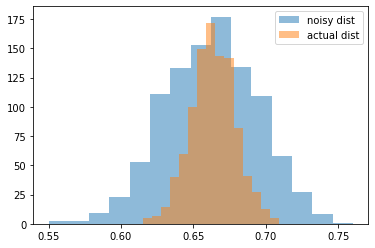

In [138]:
show_hists(p, 0.5)

As one can see from the histogram, having a randomised response mechanism creates some noise around values, and one gets a more spread distribution. However, the noisy and actual distributions both have similar averages. Thus, it looks like this can be a very accessible method for achieving some levels of privacy (for `theta=0.5` the probability of any record being associated with its true value becomes 75%)

### Step 2:  Outline of a $\epsilon$ -DP rutine on the "repaid" column


The formula for any algorithm being differentially private:

$$\left|\log\frac{\pi(a, x)}{\pi(a, x')}\right| \leq \epsilon$$

In [195]:
data_reg = np.asarray(data[1:10])
data_prime = data_reg.copy()
data_prime[-1] = 1 if data_prime[-1] == 0 else 0

In [198]:
thetas = np.linspace(0.1, 0.5, 10)
ratios = [
    np.fromiter(((randomized_response(data_reg, theta) == data_reg).all() for _ in range(1000)), bool).mean() /
    np.fromiter(((randomized_response(data_prime, theta) == data_reg).all() for _ in range(1000)), bool).mean()
    for theta in thetas
]

In [208]:
%matplotlib inline

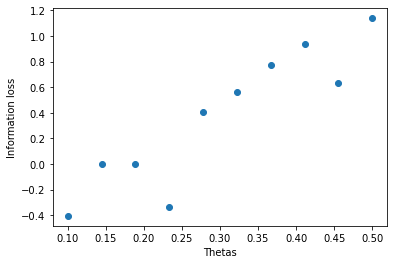

In [215]:
plt.scatter(thetas, np.log(ratios))
plt.xlabel("Thetas")
plt.ylabel("Information loss")
None